# Comparison of the data taken with a long adaptation time

(c) 2019 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT)

---

In [1]:
import os
import glob
import re

# Our numerical workhorses
import numpy as np
import scipy as sp
import pandas as pd

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the project utils
import sys
sys.path.insert(0, '../../../')
import ccutils

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline
%config InlineBackend.figure_format = 'retina'

tmpdir = '../../tmp/'
datadir = '../../../data/csv_microscopy/'

In [2]:
# Set PBoC plotting format
ccutils.viz.set_plotting_style()
# Increase dpi
mpl.rcParams['figure.dpi'] = 110

## Comparing the data

For this dataset taken on `20190814` I grew cells overnight on M9 media, the reason being that I wanted to make sure that cells had no memory of every having been in LB.

In [3]:
df_long = pd.read_csv('outdir/20190816_O2__M9_growth_test_microscopy.csv',
                     comment='#')

df_long[['date', 'operator', 'rbs', 'mean_intensity', 'intensity']].head()

,date,operator,rbs,mean_intensity,intensity
0,20190816,O2,auto,76.182410,235.982632
1,20190816,O2,auto,78.074608,215.860677
2,20190816,O2,auto,82.726588,459.562744
3,20190816,O2,auto,67.151056,213.164311
4,20190816,O2,auto,86.957315,387.342663


Now the rest of the datasets taken with the laser system

In [4]:
# Read the tidy-data frame
files = glob.glob(datadir + '/*IPTG*csv')# + mwc_files
df_micro = pd.concat(pd.read_csv(f, comment='#') for f in files if 'Oid' not in f)

##  Remove data sets that are ignored because of problems with the data quality
##  NOTE: These data sets are kept in the repository for transparency, but they
##  failed at one of our quality criteria
##  (see README.txt file in microscopy folder)
ignore_files = [x for x in os.listdir('../../image_analysis/ignore_datasets/')
                if 'microscopy' in x]
# Extract data from these files
ignore_dates = [int(x.split('_')[0]) for x in ignore_files]

# Remove these dates
df_micro = df_micro[~df_micro['date'].isin(ignore_dates)]

# Keep only the O2 operator
df_micro = df_micro[df_micro.operator == 'O2']

df_micro[['date', 'operator', 'rbs', 'mean_intensity', 'intensity']].head()

/Users/razo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


,date,operator,rbs,mean_intensity,intensity
0,20181018,O2,auto,88.876915,502.830035
1,20181018,O2,auto,99.759342,393.291230
2,20181018,O2,auto,94.213193,552.315421
3,20181018,O2,auto,92.993102,426.131591
4,20181018,O2,auto,94.591855,455.251678


Let's now look at the O2 $\Delta lacI$ strain data. For this we first have to extract the mean autofluorescence value. First let's process the new data.

In [5]:
# Define names for columns in dataframe
names = ['date', 'IPTG_uM','operator', 'binding_energy',
        'rbs', 'repressors', 'mean', 'std', 'noise']

# Initialize df_long frame to save the noise
df_noise_long = pd.DataFrame(columns=names)

# Extract the mean autofluorescence
I_auto = df_long[df_long.rbs == 'auto'].intensity.mean()

# Extract the strain fluorescence measurements
strain_df_long = df_long[df_long.rbs == 'delta']

# Group df_long by IPTG measurement
df_long_group = strain_df_long.groupby('IPTG_uM')
for inducer, df_long_inducer in df_long_group:
    # Append the require info
    strain_info = [20190624, 0, df_long_inducer.operator.unique()[0],
                   df_long_inducer.binding_energy.unique()[0],
                   df_long_inducer.rbs.unique()[0],
                   df_long_inducer.repressors.unique()[0],
                  (df_long_inducer.intensity - I_auto).mean(), 
                  (df_long_inducer.intensity - I_auto).std(ddof=1)]
    # Check if the values are negative for very small noise
    if strain_info[int(np.where(np.array(names) == 'mean')[0])] > 0:
        # Compute the noise
        strain_info.append(strain_info[-1] / strain_info[-2])
        # Convert to a pandas series to attach to the df_longframe
        strain_info = pd.Series(strain_info, index=names)
        # Append to the info to the df_long frame
        df_noise_long = df_noise_long.append(strain_info, 
                                               ignore_index=True)

df_noise_long.head()

,date,IPTG_uM,operator,binding_energy,rbs,repressors,mean,std,noise
0,20190624,0,O2,-13.9,delta,0,15318.793785,7281.731728,0.475346


In [6]:
# group by date and by IPTG concentration
df_group = df_micro.groupby(['date'])

# Define names for columns in data frame
names = ['date', 'IPTG_uM','operator', 'binding_energy',
        'rbs', 'repressors', 'mean', 'std', 'noise']

# Initialize data frame to save the noise
df_noise_delta = pd.DataFrame(columns=names)
for date, data in df_group:
    # Extract the mean autofluorescence
    I_auto = data[data.rbs == 'auto'].intensity.mean()
    
    # Extract the strain fluorescence measurements
    strain_data = data[data.rbs == 'delta']
    
    # Group data by IPTG measurement
    data_group = strain_data.groupby('IPTG_uM')
    for inducer, data_inducer in data_group:
        # Append the require info
        strain_info = [date, inducer, data_inducer.operator.unique()[0],
                       data_inducer.binding_energy.unique()[0],
                       data_inducer.rbs.unique()[0],
                       data_inducer.repressors.unique()[0],
                      (data_inducer.intensity - I_auto).mean(), 
                      (data_inducer.intensity - I_auto).std(ddof=1)]
        # Check if the values are negative for very small noise
        if strain_info[int(np.where(np.array(names) == 'mean')[0])] > 0:
            # Compute the noise
            strain_info.append(strain_info[-1] / strain_info[-2])
            # Convert to a pandas series to attach to the dataframe
            strain_info = pd.Series(strain_info, index=names)
            # Append to the info to the data frame
            df_noise_delta = df_noise_delta.append(strain_info, 
                                                   ignore_index=True)
    
df_noise_delta.head()

,date,IPTG_uM,operator,binding_energy,rbs,repressors,mean,std,noise
0,20161203,0.0,O2,-13.9,delta,0,18001.490853,6721.517791,0.373387
1,20180326,0.0,O2,-13.9,delta,0,8854.573359,3889.388878,0.439252
2,20180326,5000.0,O2,-13.9,delta,0,10612.993079,3433.252510,0.323495
3,20180402,0.0,O2,-13.9,delta,0,8222.580043,3762.221327,0.457548
4,20180402,5000.0,O2,-13.9,delta,0,11315.501681,3732.877677,0.329891


It seems that the noise is exactly the same for both illumination systems, ≈ 0.4-0.5.

Let's look at the ECDF of single-cell fluorescence values. For all measurements to be comparable we will plot the fold-change distribution. What this means is that we will extract the mean autofluorescence value and we will normalize by the mean intensity of the $\Delta lacI$ strain.

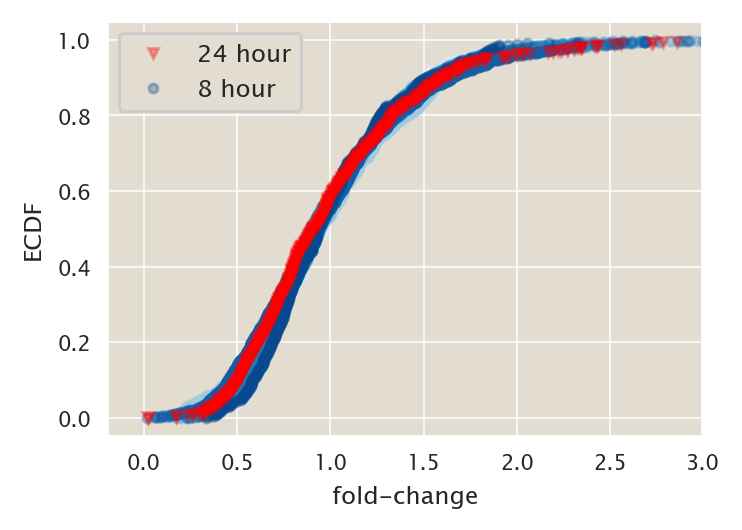

In [8]:
# group laser data by date
df_group = df_micro.groupby('date')

colors = sns.color_palette('Blues', n_colors=len(df_group))
# Loop through dates
for j, (g, d) in enumerate(df_group):
    # Extract mean autofluorescence
    auto = d.loc[d.rbs == 'auto', 'intensity'].mean()
    # Extract mean delta
    delta = d.loc[d.rbs == 'delta', 'intensity'].mean()
    # Keep only delta data
    data = d[d.rbs == 'delta']
    fold_change = (data.intensity - auto) / (delta - auto)
    # Generate ECDF
    x, y = ccutils.stats.ecdf(fold_change)
    # Plot ECDF
    plt.plot(x, y, lw=0, marker='.', color=colors[j],
               alpha=0.3, label='')

## LED
# Extract mean autofluorescence
auto_long = df_long.loc[df_long.rbs == 'auto', 'intensity'].mean()
delta_long = df_long.loc[df_long.rbs == 'delta', 'intensity'].mean()

# Compute fold-change for delta strain
fold_change = (df_long[df_long.rbs == 'delta'].intensity - auto_long) /\
              (delta_long - auto_long)
# Generate ECDF
x, y = ccutils.stats.ecdf(fold_change)
# Plot ECDF
plt.plot(x, y, lw=0, marker='v', color='red',
           alpha=0.3, label='24 hour', ms=3)

# Add fake plot for legend
plt.plot([], [], marker='.', color=colors[-1],
         alpha=0.3, label='8 hour', lw=0)

# Label x axis
plt.xlabel('fold-change')

# Add legend
plt.legend()

# Label y axis of left plot
plt.ylabel('ECDF')

# Change limit
plt.xlim(right=3)

plt.savefig('outdir/ecdf_comparison.png', bbox_inches='tight')

There is no difference whatsoever. Maybe it is not the memory of LB, but the memory of having been on a lag phase for quite a while.

## Comparison with theoretical prediction.

Let's compare these datasets with the theoretical prediction we obtained from the MaxEnt approach.

First we need to read the Lagrange multipliers to reconstruct the distribution.

In [9]:
# Define directory for MaxEnt data
maxentdir = '../../../data/csv_maxEnt_dist/'
# Read resulting values for the multipliers.
df_maxEnt = pd.read_csv(maxentdir + 'MaxEnt_Lagrange_mult_protein.csv')
df_maxEnt.head()

,operator,binding_energy,repressor,inducer_uM,lambda_m0p1,lambda_m0p2,lambda_m0p3,lambda_m0p4,lambda_m0p5,lambda_m0p6,...,m3p0,m3p1,m3p2,m3p3,m4p0,m4p1,m4p2,m5p0,m5p1,m6p0
0,O1,-15.3,0.0,0.0,0.002918,-1.853543e-07,-3.375754e-13,6.208877e-18,-8.239236e-23,-3.409273e-28,...,8592.936386,7.866644e+07,7.435490e+11,7.223464e+15,278504.362303,2.639465e+09,2.564953e+13,1.054893e+07,1.023094e+11,4.526111e+08
1,O1,-15.3,0.0,0.1,0.002918,-1.853543e-07,-3.375754e-13,6.208877e-18,-8.239236e-23,-3.409273e-28,...,8592.936386,7.866644e+07,7.435490e+11,7.223464e+15,278504.362303,2.639465e+09,2.564953e+13,1.054893e+07,1.023094e+11,4.526111e+08
2,O1,-15.3,0.0,5.0,0.002918,-1.853543e-07,-3.375754e-13,6.208877e-18,-8.239236e-23,-3.409273e-28,...,8592.936386,7.866644e+07,7.435490e+11,7.223464e+15,278504.362303,2.639465e+09,2.564953e+13,1.054893e+07,1.023094e+11,4.526111e+08
3,O1,-15.3,0.0,10.0,0.002918,-1.853543e-07,-3.375754e-13,6.208877e-18,-8.239236e-23,-3.409273e-28,...,8592.936386,7.866644e+07,7.435490e+11,7.223464e+15,278504.362303,2.639465e+09,2.564953e+13,1.054893e+07,1.023094e+11,4.526111e+08
4,O1,-15.3,0.0,25.0,0.002918,-1.853543e-07,-3.375754e-13,6.208877e-18,-8.239236e-23,-3.409273e-28,...,8592.936386,7.866644e+07,7.435490e+11,7.223464e+15,278504.362303,2.639465e+09,2.564953e+13,1.054893e+07,1.023094e+11,4.526111e+08


Now let's define the necessary objects to build the distribution from these constraints obtained with the MaxEnt method.

In [10]:
# Extract protein moments in constraints
prot_mom =  [x for x in df_maxEnt.columns if 'm0' in x]
# Define index of moments to be used in the computation
moments = [tuple(map(int, re.findall(r'\d+', s))) for s in prot_mom]

# Define sample space
mRNA_space = np.array([0])
protein_space = np.arange(0, 1.9E4)

# Extract values to be used
df_sample = df_maxEnt[(df_maxEnt.operator == 'O1') &
                      (df_maxEnt.repressor == 0) &
                      (df_maxEnt.inducer_uM == 0)]


# Select the Lagrange multipliers
lagrange_sample =  df_sample.loc[:, [col for col in df_sample.columns 
                                 if 'lambda' in col]].values[0]

# Compute distribution from Lagrange multipliers values
Pp_maxEnt = ccutils.maxent.maxEnt_from_lagrange(mRNA_space, 
                                                protein_space, 
                                                lagrange_sample,
                                                exponents=moments).T[0]

mean_p = np.sum(protein_space * Pp_maxEnt)

Now we can compare both distributions.

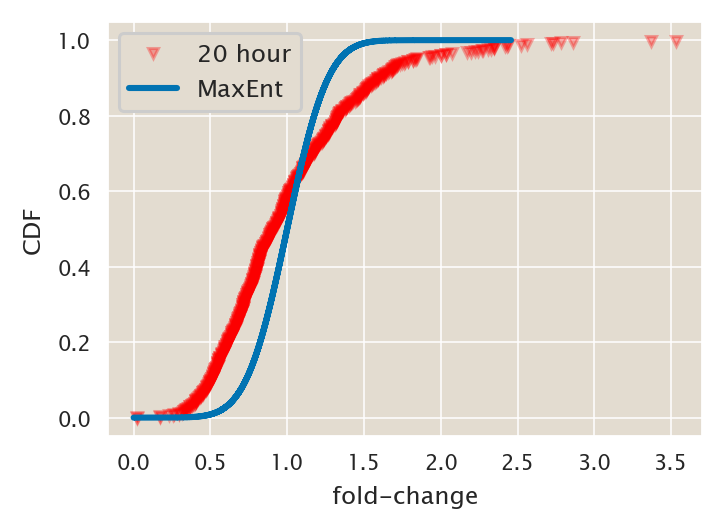

In [11]:
# Define binstep for plot, meaning how often to plot
# an entry
binstep = 10

## LED
# Extract mean autofluorescence
auto_long = df_long.loc[df_long.rbs == 'auto', 'intensity'].mean()
delta_long = df_long.loc[df_long.rbs == 'delta', 'intensity'].mean()

# Compute fold-change for delta strain
fold_change = (df_long[df_long.rbs == 'delta'].intensity - auto_long) /\
              (delta_long - auto_long)
# Generate ECDF
x, y = ccutils.stats.ecdf(fold_change)

# Plot ECDF
plt.plot(x, y, lw=0, marker='v', color='red',
           alpha=0.3, label='20 hour', ms=3)

# Plot MaxEnt results
plt.plot(protein_space[0::binstep] / mean_p, np.cumsum(Pp_maxEnt)[0::binstep],
         drawstyle='steps', label='MaxEnt', lw=2)

# Add legend
plt.legend()
# Label axis
plt.ylabel('CDF')
plt.xlabel('fold-change')

plt.savefig('outdir/maxent_comparison.png', bbox_inches='tight')